In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct
 
# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)

# Grid Field (Voxel Representation)

In [2]:
from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.001)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [25]:
print(masked_kspace.shape, mask.shape, csm.shape)

torch.Size([15, 640, 368, 2]) torch.Size([1, 1, 368, 1]) torch.Size([15, 640, 368, 2])


In [27]:
params, image_list = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=200,
    device=torch.device("cuda"),
)

iteration 1, loss: 2.971625804901123
iteration 2, loss: 2.9710206985473633
iteration 3, loss: 2.9704153537750244
iteration 4, loss: 2.9698104858398438
iteration 5, loss: 2.969205617904663
iteration 6, loss: 2.9686009883880615
iteration 7, loss: 2.96799635887146
iteration 8, loss: 2.9673919677734375
iteration 9, loss: 2.966787576675415
iteration 10, loss: 2.966183662414551
iteration 11, loss: 2.9655795097351074
iteration 12, loss: 2.964975595474243
iteration 13, loss: 2.964371681213379
iteration 14, loss: 2.9637680053710938
iteration 15, loss: 2.9631645679473877
iteration 16, loss: 2.9625608921051025
iteration 17, loss: 2.9619574546813965
iteration 18, loss: 2.9613542556762695
iteration 19, loss: 2.9607512950897217
iteration 20, loss: 2.960148572921753
iteration 21, loss: 2.959545850753784
iteration 22, loss: 2.9589433670043945
iteration 23, loss: 2.958340644836426
iteration 24, loss: 2.957738161087036
iteration 25, loss: 2.9571361541748047
iteration 26, loss: 2.9565341472625732
iterati

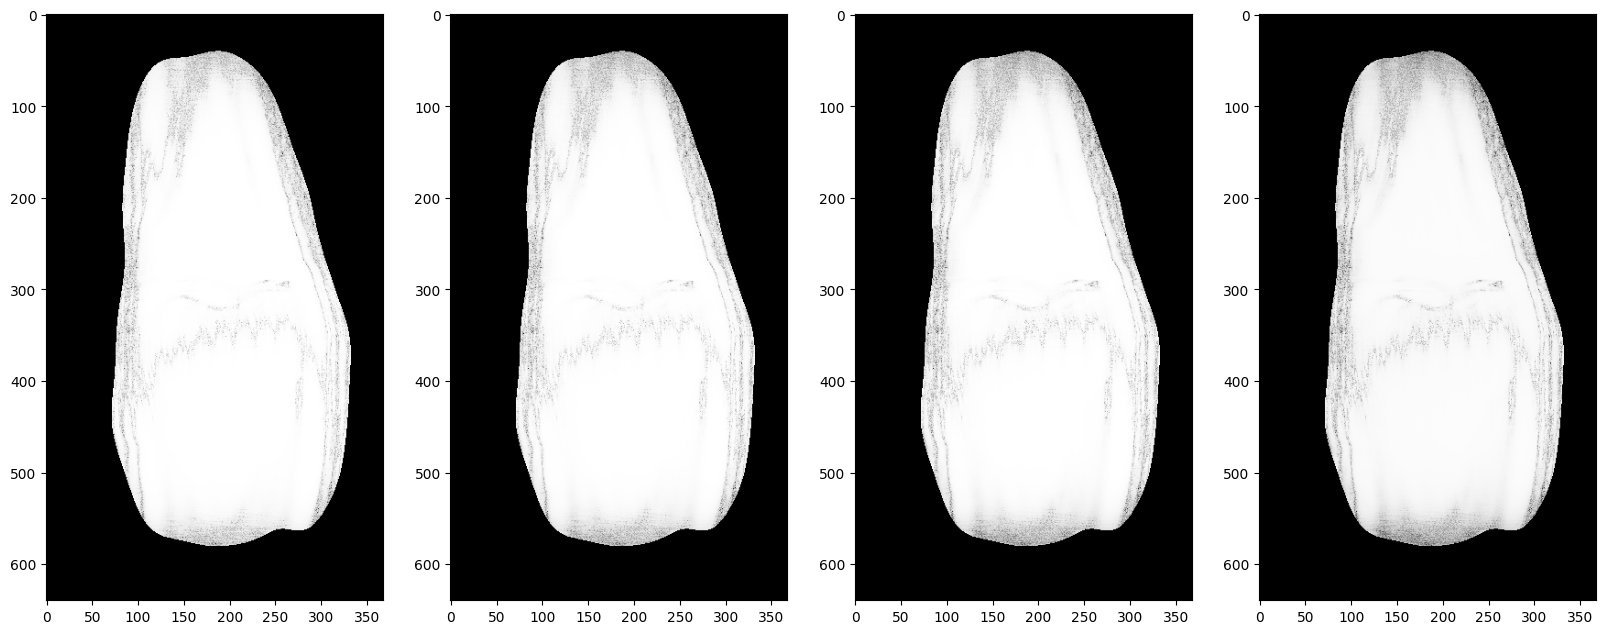

In [28]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")

# SIREN

In [30]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cuda")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=128,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-3)
# 1e-4 1.092077389
# 1e-3 0.08540542

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [31]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=1000,
    device=device,
)

iteration 1, loss: 2.9437503814697266
iteration 2, loss: 2.887876510620117
iteration 3, loss: 2.8432199954986572
iteration 4, loss: 2.9017083644866943
iteration 5, loss: 2.7693581581115723
iteration 6, loss: 2.7330093383789062
iteration 7, loss: 2.6907951831817627
iteration 8, loss: 2.6340737342834473
iteration 9, loss: 2.595216989517212
iteration 10, loss: 2.5359244346618652
iteration 11, loss: 2.4904048442840576
iteration 12, loss: 2.435459613800049
iteration 13, loss: 2.3814616203308105
iteration 14, loss: 2.325958251953125
iteration 15, loss: 2.2726705074310303
iteration 16, loss: 2.2174408435821533
iteration 17, loss: 2.1643409729003906
iteration 18, loss: 2.1123592853546143
iteration 19, loss: 2.061497926712036
iteration 20, loss: 2.0126566886901855
iteration 21, loss: 1.969317078590393
iteration 22, loss: 1.9437803030014038
iteration 23, loss: 1.9180978536605835
iteration 24, loss: 1.8507941961288452
iteration 25, loss: 1.7970589399337769
iteration 26, loss: 1.7754876613616943
i

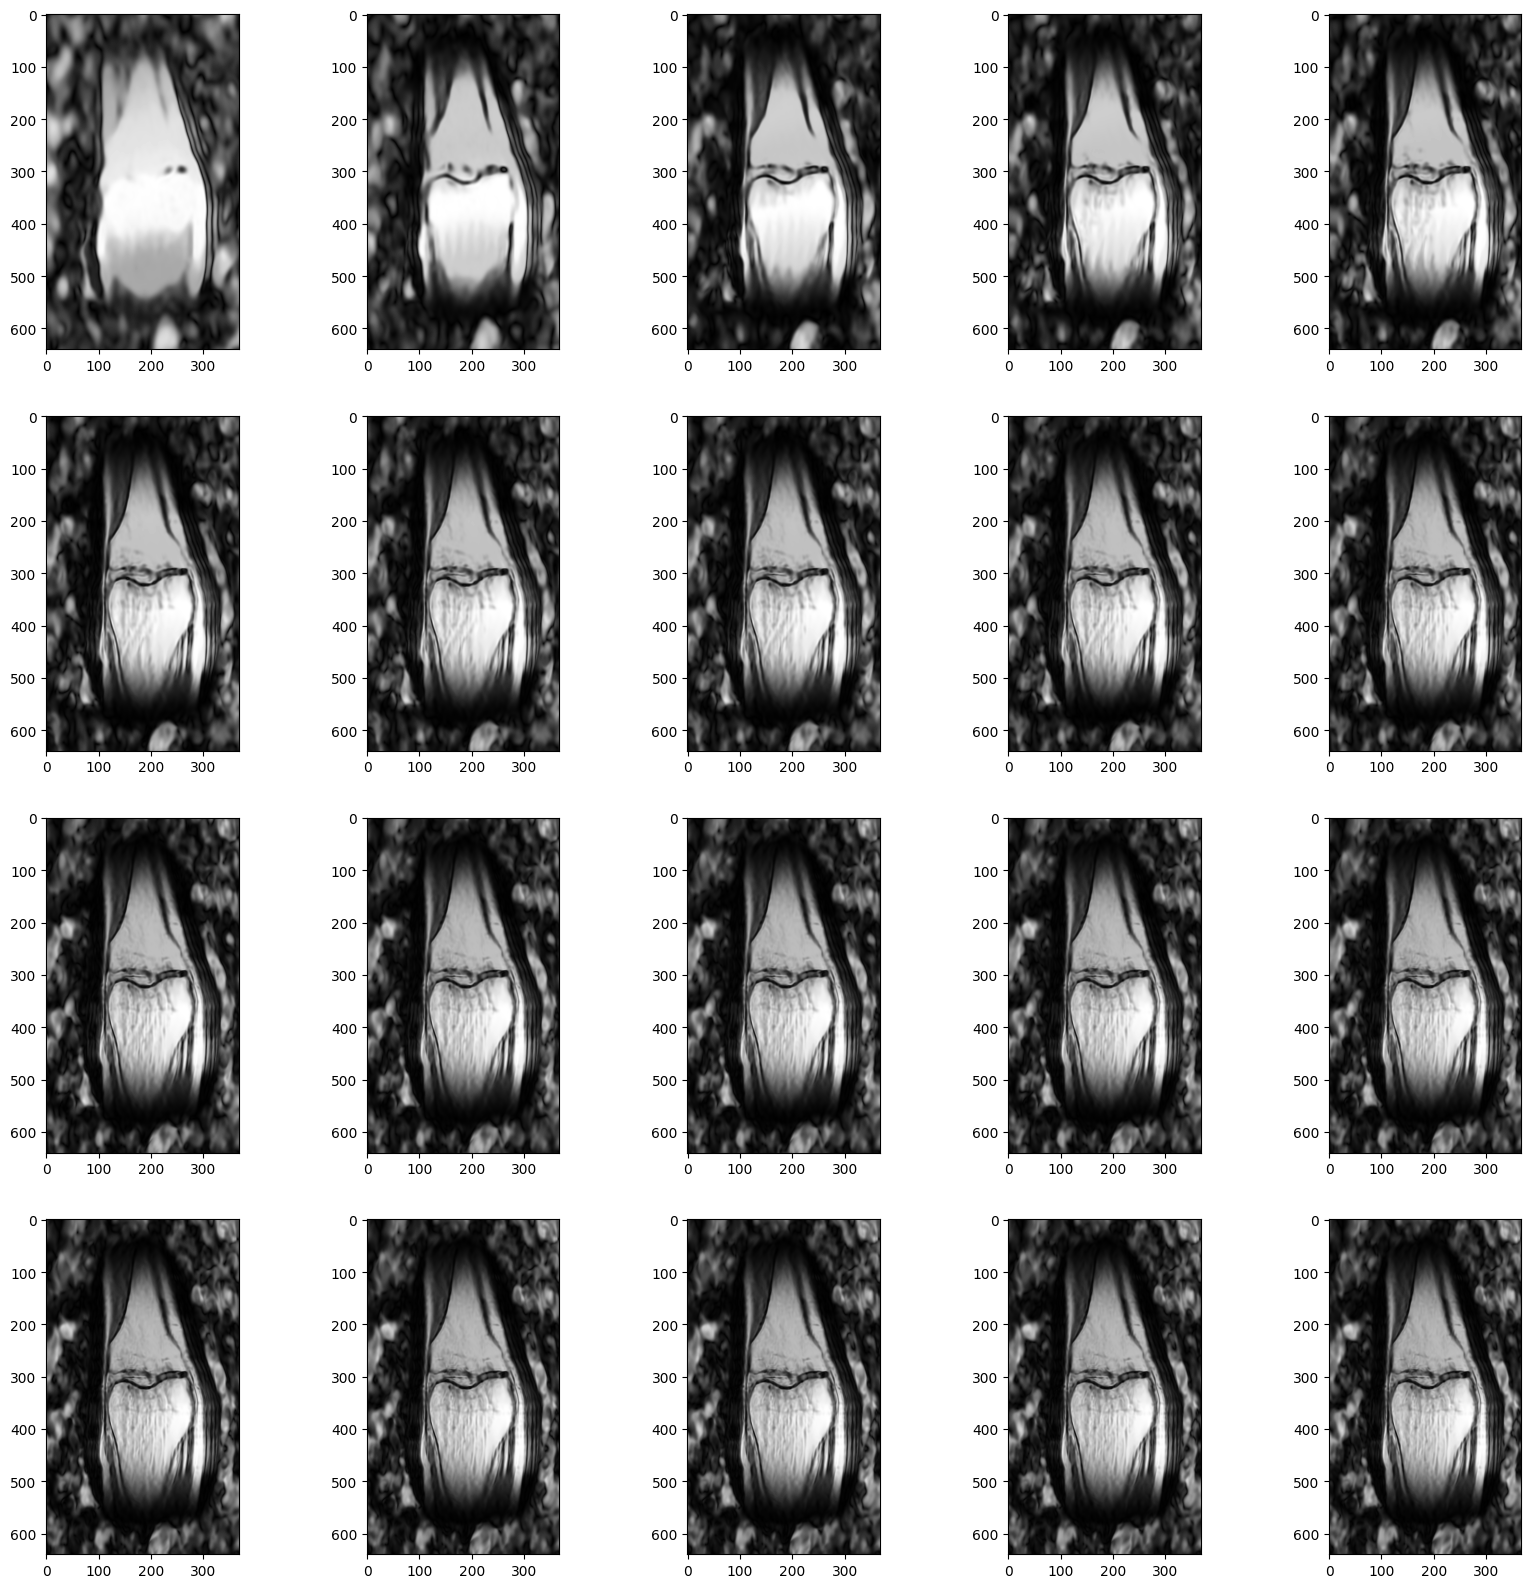

In [32]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
for i, image in enumerate(image_list):
    axs[i // 5, i % 5].imshow(complex_abs(image), cmap="gray")

In [3]:
import numpy as np
from omegaconf import OmegaConf
#from torch.utils.data import DataLoader
#from datalo

base_conf = OmegaConf.load('/bmrc-homes/nmrgrp/nmr219/ese5934_project/defaults.yaml')
second_conf = OmegaConf.load('/bmrc-homes/nmrgrp/nmr219/ese5934_project/image.yaml')
cfg = OmegaConf.merge(base_conf, second_conf)

In [57]:
from ese5934_project.models.FactorFields import DictField

cfg.dataset.aabb = [[0., 0.], [640, 368]]
device=torch.device("cuda")

model = DictField(cfg, device)

[1, 32, 32, 32]
torch.Size([32, 1024])
[1, 32, 51, 51]
torch.Size([32, 2601])
[1, 32, 70, 70]
torch.Size([32, 4900])
[1, 16, 89, 89]
torch.Size([16, 7921])
[1, 16, 108, 108]
torch.Size([16, 11664])
[1, 16, 128, 128]
torch.Size([16, 16384])
=====> total parameters:  857712


In [65]:
from ese5934_project.models.FactorFields import get_coordinates

device = torch.device("cuda")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
optimizer = torchopt.adamw(lr=1e-3)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [66]:
params, image_list = reconstruct(
    model,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=1000,
    device=device,
)

torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 1, loss: 1.8098405599594116
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 2, loss: 1.80979585647583
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 3, loss: 1.8097097873687744
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 4, loss: 1.8096593618392944
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 5, loss: 1.8095968961715698
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 6, loss: 1.8095229864120483
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 7, loss: 1.8094537258148193
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 8, loss: 1.8093928098678589
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 9, loss: 1.8093327283859253
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
iteration 10, loss: 1.8092683553695679
torch.Size([640, 368, 2]) torch.Size([15, 640, 368, 2])
itera

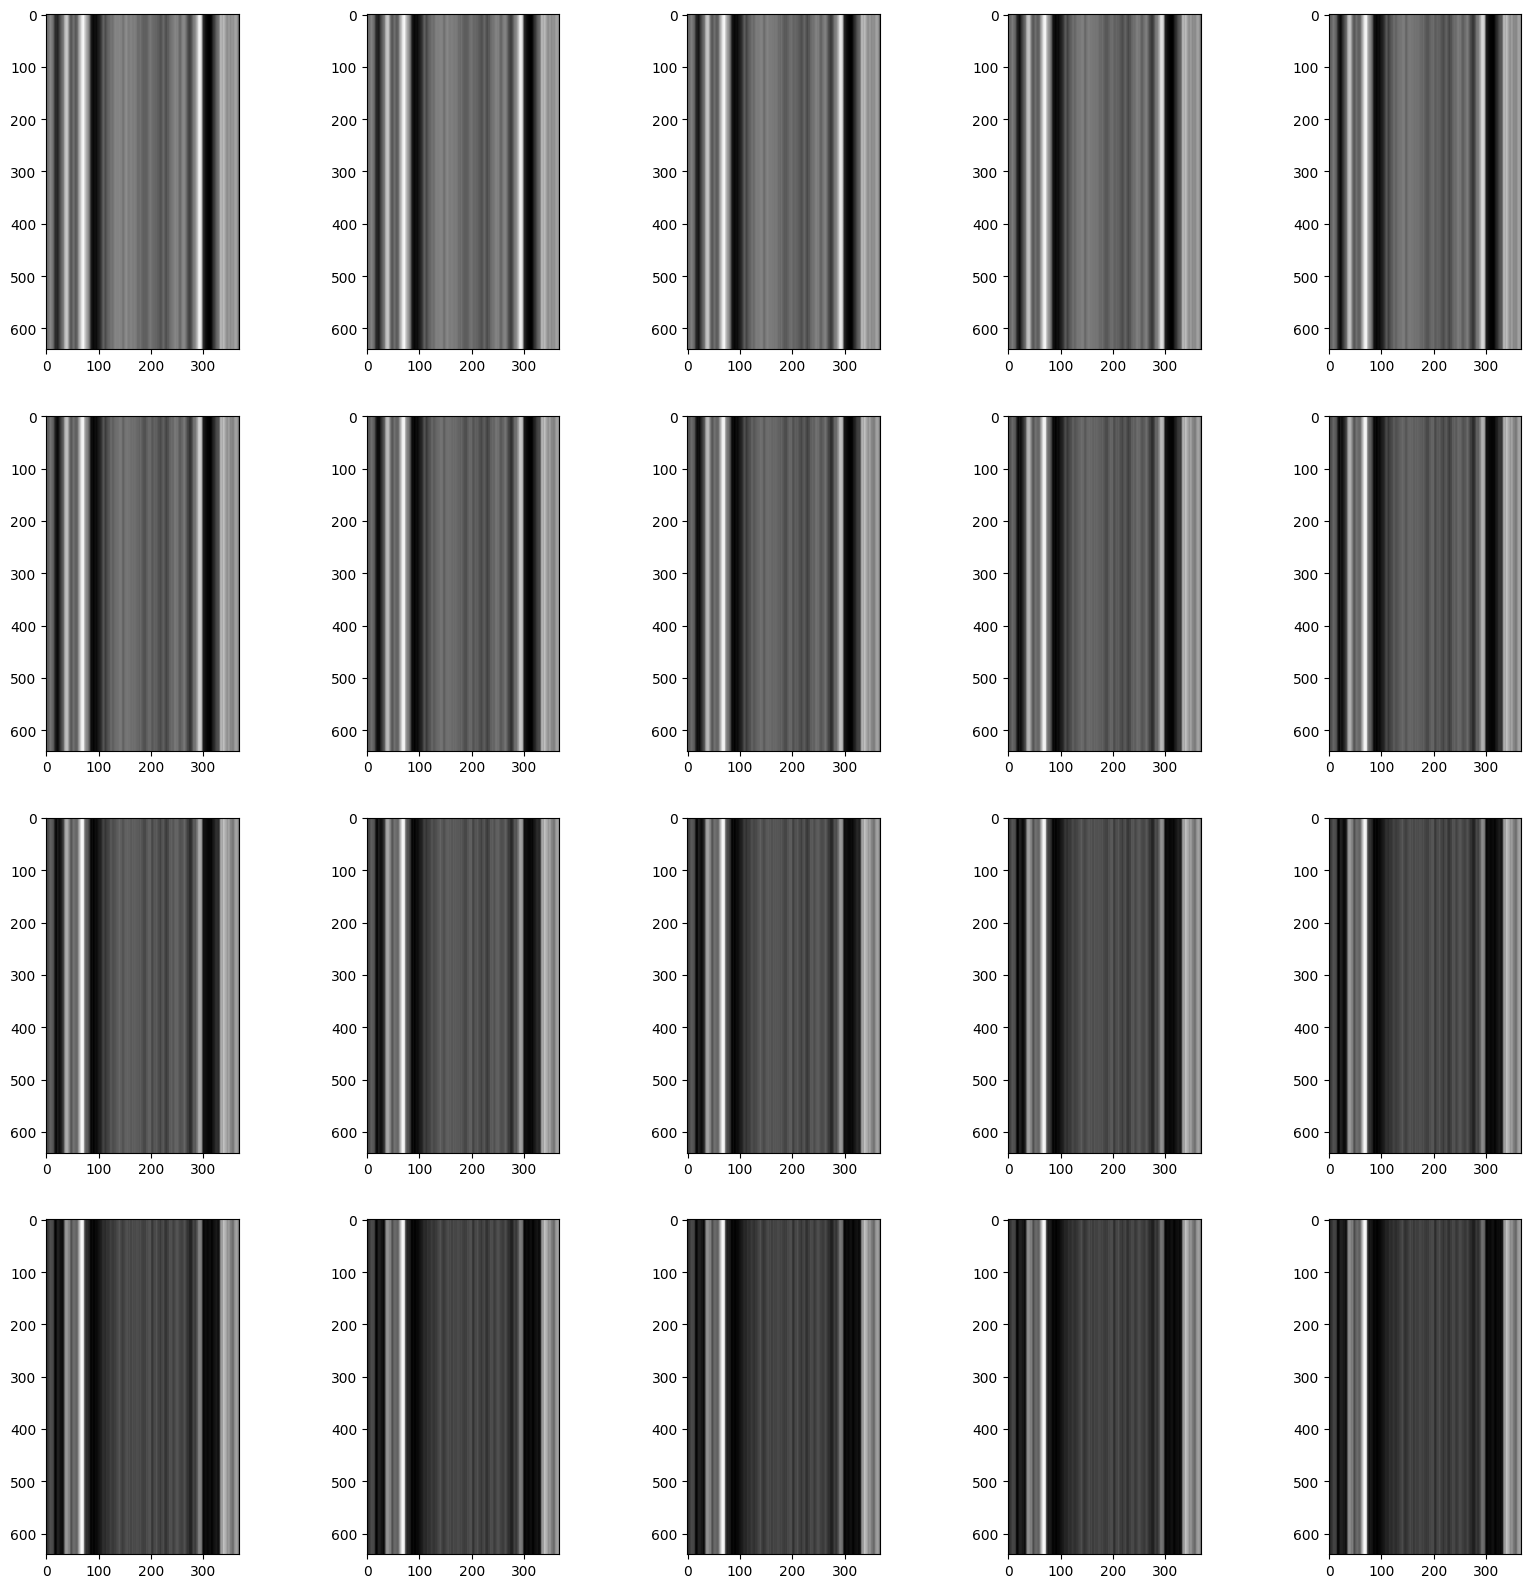

In [67]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
for i, image in enumerate(image_list):
    axs[i // 5, i % 5].imshow(complex_abs(image), cmap="gray")